In [1]:
import os
os.chdir("../")
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import torch
from gpytorch.kernels import RBFKernel, ScaleKernel, PeriodicKernel, MaternKernel, CosineKernel
from skgpytorch.models import SVGPRegressor, SGPRegressor

In [3]:
import jax.numpy as jnp
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from utilities.fits import fit
# from utilities import plot
import tensorflow_probability.substrates.jax as tfp
dist = tfp.distributions
import pandas as pd
import jax.numpy as jnp
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from gpytorch.constraints import GreaterThan
from skgpytorch.metrics import mean_squared_error, negative_log_predictive_density
import time
import numpy as np

# from datasets.dataset_load import dataset_loader
from utilities import plot,fits,gmm,errors,predict,preprocess

# device = "cpu"
# torch.set_default_dtype(torch.float32)
# torch.set_default_tensor_type(torch.FloatTensor)


In [4]:
train ={1:{
                    'start_time': "2011-04-21" ,
                    'end_time': "2011-05-21"
                },
                5: {
                    'start_time': "2011-04-22" ,
                    'end_time': "2011-06-01"
                }  ,3: {
                    'start_time': "2011-04-19" ,
                    'end_time': "2011-05-22"
                } ,
                  
              
                  2: {
                    'start_time': "2011-04-21" ,
                    'end_time': "2011-05-21"
                }
               
                
               
                }
test = { 6: {
                    'start_time': "2011-05-25" ,
                    'end_time': "2011-06-13"
                }
           }
appliances = ["Refrigerator"]

In [5]:
import pandas as pd
import jax.numpy as jnp
from datetime import datetime
from sklearn.preprocessing import StandardScaler


def dataset_load(appliances, train, test=None):
    x_train = []
    y_train = []
    x_train_timestamp = []
    n = 149
    units_to_pad = n // 2
    scaler_x = StandardScaler()
    scaler_y = StandardScaler()
    scaler_time = StandardScaler()
    # train
    for key, values in train.items():
        df = pd.read_csv(
            f"datasets/Building{key}_NILM_data_basic.csv", usecols=["Timestamp", "main", appliances[0]])
        df["date"] = pd.to_datetime(df["Timestamp"]).dt.date
        startDate = datetime.strptime(values["start_time"], "%Y-%m-%d").date()
        endDate = datetime.strptime(values["end_time"], "%Y-%m-%d").date()

        if startDate > endDate:
            raise "Start Date must be smaller than Enddate."

        df = df[(df["date"] >= startDate) & (df["date"] <= endDate)]
        df.dropna(inplace=True)
        x = df["main"].values
        y = df[appliances[0]].values
        timestamp_train = (pd.to_datetime(df["Timestamp"]).astype(int)/ 10**18).values
        x = jnp.pad(x, (units_to_pad, units_to_pad),
                    'constant', constant_values=(0, 0))
        x = jnp.array([x[i: i + n] for i in range(len(x) - n + 1)])
        x_train.extend(x)
        y_train.extend(y)
        x_train_timestamp.extend(torch.tensor(timestamp_train))


    x_train = jnp.array(x_train)
    y_train = jnp.array(y_train).reshape(-1, 1)
    x_train_timestamp = torch.tensor(x_train_timestamp).reshape(-1,1)
    x_train = scaler_x.fit_transform(x_train)
    y_train = scaler_y.fit_transform(y_train)
    x_train_timestamp = scaler_time.fit_transform(x_train_timestamp)


    # test
    x_test = []
    y_test = []
    x_test_timestamp = []
    x_test_timestamp_true =[]
    for key, values in test.items():
        df = pd.read_csv(
            f"datasets/Building{key}_NILM_data_basic.csv", usecols=["Timestamp", "main", appliances[0]])
        df["date"] = pd.to_datetime(df["Timestamp"]).dt.date
        startDate = datetime.strptime(values["start_time"], "%Y-%m-%d").date()
        endDate = datetime.strptime(values["end_time"], "%Y-%m-%d").date()

        if startDate > endDate:
            raise "Start Date must be smaller than Enddate."

        df = df[(df["date"] >= startDate) & (df["date"] <= endDate)]
        df.dropna(inplace=True)
        x = df["main"].values
        y = df[appliances[0]].values
        timestamp_true = df["Timestamp"].values
        timestamp = (pd.to_datetime(df["Timestamp"]).astype(int)/ 10**18).values
        x = jnp.pad(x, (units_to_pad, units_to_pad),
                    'constant', constant_values=(0, 0))
        x = jnp.array([x[i: i + n] for i in range(len(x) - n + 1)])
        x_test.extend(x)
        y_test.extend(y)
        x_test_timestamp_true.extend(timestamp_true)
        x_test_timestamp.extend(timestamp)

    x_test = jnp.array(x_test)
    y_test = jnp.array(y_test).reshape(-1, 1)
    x_test_timestamp = torch.tensor(x_test_timestamp).reshape(-1,1)

    x_test = scaler_x.transform(x_test)
    x_test_timestamp = scaler_time.transform(x_test_timestamp)
#     y_test = scaler_y.transform(y_test)

    x_train = jnp.array(x_train).reshape(x_train.shape[0], n, 1)
    y_train = jnp.array(y_train)
    x_train_timestamp = torch.tensor(x_train_timestamp).reshape(x_train_timestamp.shape[0], 1)
    x_test = jnp.array(x_test).reshape(x_test.shape[0], n, 1)
    y_test = jnp.array(y_test)
    x_test_timestamp = torch.tensor(x_test_timestamp).reshape(x_test_timestamp.shape[0], 1).to(torch.float64)

    return x_train, y_train, x_test, y_test, x_train_timestamp, x_test_timestamp, x_test_timestamp_true, scaler_x, scaler_y, scaler_time


In [6]:
x_train, y_train, x_test, y_test, x_train_timstamp, x_test_timestamp, test_timestamp_orig, scaler_x, scaler_y, scaler_time = dataset_load(appliances, train, test)

In [7]:
n = 149
# x_train_full = jnp.concatenate((x_train.reshape(-1,n), jnp.array(np.array(x_train_timstamp))), axis=1)
# x_test_full = jnp.concatenate((x_test.reshape(-1,n), jnp.array(np.array(x_test_timestamp))), axis=1)
# x_train_full.shape, x_test_full.shape

In [8]:
x_train.reshape(-1,n).shape, x_test.reshape(-1,n).shape, y_train.shape, y_test.shape

((53456, 149), (16781, 149), (53456, 1), (16781, 1))

In [9]:
indexes = 53456
x = torch.tensor(np.array(x_train).reshape(-1,n)).to(torch.float64)
y = torch.tensor(np.array(y_train)).reshape(-1,).to(torch.float64)
xt = torch.tensor(np.array(x_test).reshape(-1,n)).to(torch.float64)
yt = torch.tensor(np.array(y_test)).reshape(-1,).to(torch.float64)

if x.shape[0]>indexes:
  x = x[:indexes]
  y = y[:indexes]

# xt = xt[:16000]
# yt = yt[:16000]

restart: 0, epoch: 1, iter: 1, loss: 1.5757


/home/desai.aadesh/miniconda3/envs/nlim/lib/python3.10/site-packages/gpytorch/kernels/inducing_point_kernel.py:61: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352645774/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2183.)
  inv_root = torch.triangular_solve(eye, chol)[0]


restart: 0, epoch: 2, iter: 1, loss: 1.5576
restart: 0, epoch: 3, iter: 1, loss: 1.5427
restart: 0, epoch: 4, iter: 1, loss: 1.5301
restart: 0, epoch: 5, iter: 1, loss: 1.5189
restart: 0, epoch: 6, iter: 1, loss: 1.5088
restart: 0, epoch: 7, iter: 1, loss: 1.4996
restart: 0, epoch: 8, iter: 1, loss: 1.4911
restart: 0, epoch: 9, iter: 1, loss: 1.4832
restart: 0, epoch: 10, iter: 1, loss: 1.4759
restart: 0, epoch: 11, iter: 1, loss: 1.4689
restart: 0, epoch: 12, iter: 1, loss: 1.4623
restart: 0, epoch: 13, iter: 1, loss: 1.4560
restart: 0, epoch: 14, iter: 1, loss: 1.4500
restart: 0, epoch: 15, iter: 1, loss: 1.4442
restart: 0, epoch: 16, iter: 1, loss: 1.4386
restart: 0, epoch: 17, iter: 1, loss: 1.4332
restart: 0, epoch: 18, iter: 1, loss: 1.4281
restart: 0, epoch: 19, iter: 1, loss: 1.4231
restart: 0, epoch: 20, iter: 1, loss: 1.4183
restart: 0, epoch: 21, iter: 1, loss: 1.4137
restart: 0, epoch: 22, iter: 1, loss: 1.4093
restart: 0, epoch: 23, iter: 1, loss: 1.4051
restart: 0, epoch:

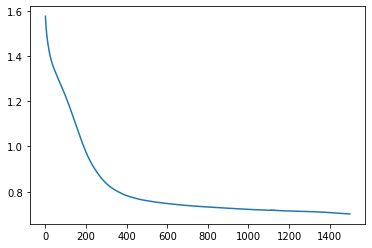

In [10]:
mae_arr =[]
rms_arr = []
y_pred_arr = []

batch = 512

# x_train = x_train[:4500]
# y_train = y_train[:4500]

# y_test_trans = torch.tensor(torch.tensor(scaler_x.transform(y_test.reshape(-1,1))).reshape(-1,)).contiguous().to(torch.float64)
for i in range(1):


   #nu=2.5,

  kernel1 = ScaleKernel(RBFKernel(ard_num_dims=n))
  # kernel2 = ScaleKernel(RBFKernel(ard_num_dims=1,active_dims=(49)))
  # kernel3 = ScaleKernel(CosineKernel(ard_num_dims=1,active_dims=(49)))

  # kernel4 = kernel2*kernel3
  kernel = kernel1 # + kernel4
  # induce_points = 512
  inducing_points =  x[np.arange(0,x.shape[0],33)] 
  # inducing_points = x[torch.randperm(x.shape[0])[: 1500]]
  
  model = SGPRegressor(x.to("cuda"), y.to("cuda"), kernel,
                       inducing_points).to("cuda")
  # model.mll.likelihood.noise_covar.register_constraint("raw_noise", GreaterThan(1e-2))
  # for param in model.parameters():
  #   # print(param)
  #   torch.nn.init.normal_(param, 0, 1)
  # theta1 = {'likelihood.noise_covar.noise': torch.tensor(3),
  #       'covar_module.base_kernel.lengthscale': torch.tensor(0.1),
  #       'covar_module.outputscale': torch.tensor(5),}
  loss = model.fit(lr=0.01, n_epochs=1500,verbose=2,
          random_state=0, n_restarts=1)
#   loss_arr.append(loss)
  # print(loss)
  plt.plot(np.asarray(loss[0]))
  # plt.plot(np.asarray(test_loss[0]))






  # y_pred_arr.append(pred_dist.loc)

  

In [11]:
model_name = "Refrigerator_seq149_final.pt"
torch.save(model.state_dict(), os.path.join(
   "./final_models/", model_name))

In [10]:
kernel1 = ScaleKernel(RBFKernel(ard_num_dims=n))
# kernel2 = ScaleKernel(RBFKernel(ard_num_dims=1,active_dims=(49)))
# kernel3 = ScaleKernel(CosineKernel(ard_num_dims=1,active_dims=(49)))

# kernel4 = kernel2*kernel3
kernel = kernel1 # + kernel4
# induce_points = 512
inducing_points =  x[np.arange(0,x.shape[0],33)] 
# inducing_points = x[torch.randperm(x.shape[0])[: 1500]]

model = SGPRegressor(x.to("cuda"), y.to("cuda"), kernel,
                      inducing_points).to("cuda")

model_name =  "Refrigerator_seq149_final.pt"
model.load_state_dict(torch.load(
    os.path.join("./final_models/", model_name)))

<All keys matched successfully>

In [11]:
for name, params in model.named_parameters():
  print(name, params)

mll.likelihood.noise_covar.raw_noise Parameter containing:
tensor([-1.5321], device='cuda:0', requires_grad=True)
mll.model.mean_module.constant Parameter containing:
tensor([0.0091], device='cuda:0', requires_grad=True)
mll.model.base_covar_module.raw_outputscale Parameter containing:
tensor(-1.7861, device='cuda:0', requires_grad=True)
mll.model.base_covar_module.base_kernel.raw_lengthscale Parameter containing:
tensor([[ 6.0224,  6.5481,  6.6917,  6.6128,  6.7233,  6.8978,  7.0728,  7.0176,
          7.0793,  6.9593,  7.0746,  7.2130,  6.9794,  6.7246,  6.3253,  6.2817,
          6.3169,  6.2835,  6.1692,  6.2901,  6.4105,  6.2472,  5.8055,  5.7883,
          5.5931,  5.4260,  5.5024,  5.3426,  4.9205,  5.2053,  5.2188,  4.9959,
          5.0102,  4.8486,  4.7764,  5.2995,  5.6437,  5.6231,  5.7279,  5.6336,
          5.3512,  4.9477,  4.9625,  4.8883,  4.1929,  4.6856,  5.3312,  5.2093,
          3.3716, -0.4142,  3.6234,  4.5655,  5.3567,  4.9626,  4.9593,  5.1607,
          3.813

In [16]:
arr = np.array([6.0224,  6.5481,  6.6917,  6.6128,  6.7233,  6.8978,  7.0728,  7.0176,
          7.0793,  6.9593,  7.0746,  7.2130,  6.9794,  6.7246,  6.3253,  6.2817,
          6.3169,  6.2835,  6.1692,  6.2901,  6.4105,  6.2472,  5.8055,  5.7883,
          5.5931,  5.4260,  5.5024,  5.3426,  4.9205,  5.2053,  5.2188,  4.9959,
          5.0102,  4.8486,  4.7764,  5.2995,  5.6437,  5.6231,  5.7279,  5.6336,
          5.3512,  4.9477,  4.9625,  4.8883,  4.1929,  4.6856,  5.3312,  5.2093,
          3.3716, -0.4142,  3.6234,  4.5655,  5.3567,  4.9626,  4.9593,  5.1607,
          3.8138,  4.2369,  4.3532,  3.9241,  3.7677,  4.0632,  4.6550,  4.5979,
          5.0159,  5.1917,  5.1057,  4.9946,  5.7537,  5.9688,  6.0974,  5.5386,
          5.0369, -0.0186, -1.9204,  1.1494,  5.1787,  4.8315,  5.0875,  4.6592,
          4.5881,  5.2014,  5.5704,  5.4786,  4.8134,  4.8922,  4.6625,  5.0757,
          4.8701,  4.2785, -0.4275,  3.6035,  4.7705,  5.5833,  5.3987,  5.4443,
          5.4355,  5.4377,  5.2838,  5.3400,  4.8410,  5.0024,  5.1862,  4.9075,
          4.9992,  5.5020,  5.6886,  5.7535,  5.9985,  6.3457,  6.0673,  6.0195,
          6.3107,  6.4503,  6.2980,  6.3321,  6.2577,  6.1232,  6.1868,  6.3696,
          5.9751,  6.1040,  6.1889,  6.2616,  6.2572,  6.1194,  6.0482,  6.1945,
          6.1810,  6.3876,  6.3238,  6.1914,  6.2270,  6.3640,  6.4837,  6.5642,
          6.6860,  6.8724,  6.9664,  6.8322,  6.6803,  6.5388,  6.4204,  6.4740])

arr[74]
# plt.plot(arr)
# plt.xlabel('ARD Coefficients')
# plt.ylabel('ARD Learned values')
# plt.title("Building 5 Test")
# plt.savefig("Building5_ARD.png")


-1.9204

In [13]:
pred_dist = model.predict(xt.to("cuda"))
# print("Done ", i)

y_mean = pred_dist.loc

/home/desai.aadesh/miniconda3/envs/nlim/lib/python3.10/site-packages/gpytorch/kernels/inducing_point_kernel.py:61: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352645774/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2183.)
  inv_root = torch.triangular_solve(eye, chol)[0]


In [14]:
y_mean = scaler_y.inverse_transform(y_mean.cpu().reshape(-1,1)).squeeze()
# y_sigma = scaler_y.inverse_transform(y_sigma.reshape(-1,1)).squeeze()
print(yt.shape, y_mean.shape)

torch.Size([16781]) (16781,)


In [15]:
mae = np.mean(np.abs(np.array(yt) - y_mean))
rms = errors.rmse(jnp.array(yt), y_mean)

print("MAE: ", mae)
print("RMSE: ", rms)

MAE:  30.068663979616744
RMSE:  46.821163
